 # Craigslist Capstone Project - Preprocessing and Modeling

This capstone project aims to develop supervised machine learning models to predict the market rent price of a property based on relevant features found on a craigslist ad for the San Francisco Bay Area. Listing data was scraped from Craigslist from August to October 2022. The metros of interest are San Francisco, Peninsula, East Bay in the Bay Area.

<br>

<div>
<img src="https://github.com/melissavhan/CapstoneTwoProject/blob/96c0464b62a9355c4c37f61c78c83c1337888718/references/Simple_bay_area_metros.JPG" width="500"/>
</div>
<br>

Prior to this notebook, [2. Data Wrangling](https://github.com/melissavhan/CapstoneTwoProject/blob/e38988da9187f9000b49eb6948fd67ea25cd89af/notebooks/Craigslist_Data_Wrangling%20.ipynb) was done on the scraped craigslist data and [3. Exploratory data analysis](https://github.com/melissavhan/CapstoneTwoProject/blob/e38988da9187f9000b49eb6948fd67ea25cd89af/notebooks/Craigslist_EDA.ipynb) was performed and correlations between variables plotted.

## This notebook covers the scope of
### 4. Preprocessing steps

+ [Splitting the data into testing and training datasets](#1)
+ [Handle missing values](#2) 
+ [Removing outliers](#3)
+ [Feature engineering for categorical variables](#4)
+ [Scaling numeric data](#5)


### 5. Build some Machine learning models:
1. [Baseline Model using only neighborhood and square footage features](#6)
2. [Stochastic Gradient Descent Regressor](#7) 
3. [Random Forest Model](#8) 
4. [XGBoost](#9) 
5. [LGBM Regressor](#10) 
6. [Piecewise model (SGDR) by number of bedrooms](#11) 
7. [Piecewise model (SGDR) by neighborhood](#12) 

### Results and interpretation
+ [Model metrics and results](#13)
+ [Feature exploration and interpretability](#14)
+ [Applications of the model for renters and property owners](#15)


## Importing the libraries

In [120]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
from sklearn import __version__ as sklearn_version
from sklearn.linear_model import ElasticNet, LinearRegression, SGDRegressor 
from sklearn.ensemble import RandomForestRegressor
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

In [121]:
# Create an option to display printed results from model runs
VERBOSE=False

## Load Data

In [122]:
# The data is the interim directory
df = pd.read_csv('/Users/pandabear/springboard/CapstoneTwoProject/data/interim/listing_df_EDA.csv',index_col='listing_id')
# Drop listing_city 
df.drop(['listing_city'], axis=1, inplace=True)
df

,listing_nh,listing_price,listing_sqft,listing_address,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,hasEVCharging,...,is_rent_controlled,pets_allowed,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO
listing_id,,,,,,,,,,,,,,,,,,,,,
7520103440,fremont / union city / newark,3800,1495.0,Newport Dr,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
7520905091,vallejo / benicia,2100,904.0,226 Edgemont Avenue near Edgemont Avenue,1,1,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
7520907681,vallejo / benicia,2200,1420.0,1509 Sacramento Street near Sacramento Street,1,1,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
7520608095,dublin / pleasanton / livermore,3935,1266.0,1552 E Gate Way,1,1,1,0,1,0,...,0,0,1,1,0,0,0,1,0,0
7520200206,dublin / pleasanton / livermore,3000,NaN,2380 Nissen Drive,1,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539192775,downtown / civic / van ness,6775,2540.0,"1888 Geneva Ave, 403 near Carter",0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,0
7527460081,inner richmond,3500,1100.0,404 12th Ave #4 near Geary Blvd,0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
7536441224,tenderloin,2195,NaN,725 Ellis St near Hyde,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id="1"></a> 
## 1. Split the data into testing and training datasets

In [123]:
y = df['listing_price']
X = df
# Split the dataframe into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=1,shuffle=True)

In [124]:
# Create an extra copy for later use
X_train_preprocess = X_train.copy()
X_test_preprocess = X_test.copy()

In [125]:
# nh_listings_test = X_train.groupby(['listing_nh','no_bedrooms'])['listing_price'].mean().reset_index()
# nh_listings_test.rename(columns = {'listing_price':'average_price_by_nh_by_bedroom'}, inplace = True)
# nh_listings_test

In [126]:
# nh_listings_test['average_price_by_nh_by_bedroom'].mean()

In [127]:
y_train.shape, y_test.shape

((9114,), (3906,))

In [128]:
# Save the index to put back after scaling
X_train_index = X_train.index
X_test_index = X_test.index

# Save a copy of X_train and X_test for the baseline model (no pipeline)
X_train_baseline = X_train.copy()
X_test_baseline = X_test.copy()

<a id="2"></a> 
## 2. Handle missing values

In [129]:
missing = pd.concat([X_train.isnull().sum(), 100 * X_train.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
listing_sqft,2859,31.369322
transit_score,1776,19.486504
bike_score,1253,13.748080
walk_score,302,3.313583
listing_address,234,2.567479
listing_nh,0,0.000000
is_rent_controlled,0,0.000000
housing_flat,0,0.000000
housing_house,0,0.000000
housing_townhouse,0,0.000000


The missing addresses are ok to ignore since we will not be using that feature directly. The neighborhood and walk_score, transit_score, bike_scores are better representations of how desirable a property is compared to the exact address.

### Impute any missing square footage values 
Let's use the median value for the listing's number of bedroom/bathroom

In [130]:
# Create a class that imputes missing square footage values from training data
class ImputeMissingSqft:
        
    def fit(self, X, y=None):
        # Group by bedrooms and bathrooms to find median square footage
        self.missing_sqft = X.groupby(by=['no_bedrooms','no_bathrooms']).median()['listing_sqft'].reset_index()
        self.missing_sqft.rename(columns = {'listing_sqft':'listing_sqft_median'}, inplace = True)
        mean_sqft_by_bedroom = self.missing_sqft.groupby(by='no_bedrooms').mean().reset_index()[['no_bedrooms','listing_sqft_median']]
        
        # Create a dictionary of the average sqft by bedrooms
        self.mean_sqft_by_bedroom_dict = mean_sqft_by_bedroom.set_index('no_bedrooms').to_dict()['listing_sqft_median']
        
        # Fillna for the missing values in the dictionary
        self.missing_sqft.loc[self.missing_sqft['listing_sqft_median'].isnull(),'listing_sqft_median'] = self.missing_sqft['no_bedrooms'].map(self.mean_sqft_by_bedroom_dict)
        return self
    
    def transform(self, X):
        # Left join on bedrooms and bathrooms and use the median column if listing_sqft is null
        combined_df = X.merge(self.missing_sqft, on=['no_bedrooms','no_bathrooms'], how='left')
        
        combined_df['listing_sqft'].fillna(combined_df['listing_sqft_median'], inplace=True)
        
        # Fillna with the median listing_sqft value by bedroom only if it is a combination not seen before
        combined_df['listing_sqft'].fillna(combined_df['no_bedrooms'].map(self.mean_sqft_by_bedroom_dict), inplace=True)
        
        # Drop the extra column
        combined_df.drop(['listing_sqft_median'], axis=1, inplace=True)
        X = combined_df
        return X

### Impute any missing Walk score, Transit Score, Bike Score values
Let's use the median value for the listing's neighborhood. All transit scores range from 0 to 100

In [131]:
# Create a class that imputes missing walk, bike and transit scores from training data using the median value from the listing's neighborhood.
class ImputeMissingWalkscore:
        
    def fit(self, X, y=None):
        # Group by neighborhood to find median walks_score, transit_score, bike_score
        self.median_scores = X.groupby(by=['listing_nh']).median()[['walk_score','transit_score','bike_score']].reset_index()
        self.median_scores.rename(columns = {'walk_score':'median_walk_score','transit_score':'median_transit_score','bike_score':'median_bike_score'}, inplace = True)
        self.median_scores.fillna(0, inplace=True)
        return self
    
    def transform(self, X):
        # Left join on neighborhoods
        nh_df = X.merge(self.median_scores, on=['listing_nh'], how='left')

        # Use the mean score values if walk_score, transit_score or bike_score is null
        nh_df['walk_score'].fillna(nh_df['median_walk_score'],inplace=True)
        nh_df['transit_score'].fillna(nh_df['median_transit_score'],inplace=True)
        nh_df['bike_score'].fillna(nh_df['median_bike_score'],inplace=True)

        # In case there is a new neighborhood that doesn't have a mean walk/bike/transit score, use the mean of median_scores to fill null values
        nh_df['walk_score'].fillna(self.median_scores['median_walk_score'].mean(),inplace=True)
        nh_df['transit_score'].fillna(self.median_scores['median_transit_score'].mean(),inplace=True)
        nh_df['bike_score'].fillna(self.median_scores['median_bike_score'].mean(),inplace=True)
        
        # Drop unused columns
        nh_df.drop(['median_walk_score','median_transit_score','median_bike_score','listing_address'], axis=1,inplace=True)

        X = nh_df
        return X

<a id="3"></a> 
## 3. Remove outliers
### For studio listings
During EDA, it became clear that studio listing prices had a very long tail - possibly because some listings were misclassified as studios when they should have been 1 or 2 bedroom apartments. 
To remove these outliers, cap the prices of studios to the 99th percentile

In [132]:
class RemoveOutliersStudios:
    def fit(self, X, y=None):
        # Cap the top 1% percentile of all listing_price for studios
        self.upper_lim = X[X['no_bedrooms'] == 0]['listing_price'].quantile(q = 0.99)
        return self
    
    def transform(self, X):
        X.loc[(X['listing_sqft'] > self.upper_lim) & (X['no_bedrooms'] == 0),'listing_price'] = self.upper_lim
        # Drop listing_price column
        X.drop(['listing_price'], axis=1, inplace=True)
        
        return X

### For listing square footage grouped by number of bedrooms
To remove outliers, also cap the listing's square footage values by three times the standard deviation above the median square footage for the given number of bedrooms. 

In [133]:
class CapOutliersSquareFootageByBedroom:
    def fit(self, X, y=None):
        grouped_bed_median = X.groupby(by=['no_bedrooms']).median()[['listing_sqft']].reset_index()
        grouped_bed_std = X.groupby(by=['no_bedrooms']).std()[['listing_sqft']].reset_index()
        self.sqft = pd.merge(grouped_bed_median, grouped_bed_std, on = "no_bedrooms", how = "inner")
        self.sqft.rename(columns = {'listing_sqft_x':'median_sqft', 'listing_sqft_y':'std_sqft'}, inplace = True)
        
        # Calculate the upper limit
        self.sqft['upper_lim'] = self.sqft.apply(lambda row: row['median_sqft'] + row['std_sqft'] * 3, axis = 1).astype(int)
        return self
    
    def transform(self, X):
        X = X.merge(self.sqft[['no_bedrooms','upper_lim']], on=['no_bedrooms'], how='left')
        X['listing_sqft'] = np.where((X['listing_sqft'] > X['upper_lim']), X['upper_lim'], X['listing_sqft'])
        # Drop upper_lim column
        X.drop(['upper_lim'], axis=1, inplace=True)
        return X

<a id="4"></a> 
## 4. Feature engineering for categorical variables
The remaining categorical features are neighborhood and city. Since a city includes multiple neighborhoods, we can use the neighborhood feature in lieu of the city feature entirely. 
The most common size of rental units are 1 bedroom/1 bathroom ones. There are too many neighborhoods to one hot encode so instead impute using the mean price per 1 bedroom/1 bathroom listing for that neighborhood or city. 

Let's create or own Estimator to replace the categorical feature neighborhoods to the average listing price of 1 bedroom/1 bathroom places for each neighborhood. 

In [134]:
# List all the unique neighborhoods in the entire dataset
unique_nh = df.listing_nh.unique()
print(f'There are {len(unique_nh)} unique neighborhoods in the dataframe')

There are 81 unique neighborhoods in the dataframe


In [135]:
class NHAveragePrice:
# Group by neighborhood and square footage

    def fit(self, X, y=None):
        # Group by neighborhood and square footage
        X['price_per_sqft'] = X['listing_price']/X['listing_sqft']
        self.nh_price = X.groupby(['listing_nh'])['price_per_sqft'].mean().reset_index()
        X.drop(['price_per_sqft'], axis=1, inplace=True)

        return self
    
    def transform(self, X):
        avg_nh_df = X.merge(self.nh_price, on=['listing_nh'], how='left')
        
        # If there is a neighborhood not seen in the training set, impute the median value for all neighborhoods
        avg_nh_df['price_per_sqft'].fillna(self.nh_price['price_per_sqft'].median(), inplace=True)
        #avg_nh_df['price_estimate_sqft_nh'] = avg_nh_df['price_per_sqft'] * avg_nh_df['listing_sqft']
        avg_nh_df.drop(['listing_nh'], axis=1,inplace=True)
        X = avg_nh_df
        return X


<a id="5"></a> 
## 5. Standardize numeric features

In [136]:
class DataframeStandardScaler:
    def __init__(self, columns):
        self.columns = columns
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self
    
    def transform(self, X):
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X

In [137]:
nh = NHAveragePrice()
sqft1 = ImputeMissingSqft()
walk = ImputeMissingWalkscore()
outliers = RemoveOutliersStudios()
sqft2 = CapOutliersSquareFootageByBedroom()
scale = DataframeStandardScaler(['listing_sqft','walk_score','transit_score','bike_score','no_bedrooms','no_bathrooms','price_per_sqft'])

p = Pipeline([
    ('impute_missing_sqft', sqft1),
    ('impute_missing_walkscore', walk),
    ('nh_average_price', nh),
    ('remove_outliers_studios', outliers),
    ('Cap_Outliers_Square_Footage_By_Bedroom', sqft2),
    ('standard_scaler', scale)
])

X_train = p.fit_transform(X_train)
X_test = p.transform(X_test)

In [138]:
# Assign index back
X_train.index = X_train_index
X_test.index = X_test_index
X_train

,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,hasEVCharging,laundry_in_bldg,laundry_in_unit,laundry_has_hookup,...,pets_allowed,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO,price_per_sqft
listing_id,,,,,,,,,,,,,,,,,,,,,
7528793348,-0.524729,1,1,1,1,0,0,1,0,0,...,0,1,1,0,1,0,1,0,0,-1.057284
7545258880,-0.420741,1,1,0,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,0.191849
7531027707,-0.639116,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,-0.295956
7527961577,-0.639116,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0.364560
7539013680,-0.639116,1,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0.615054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7517059848,1.498879,1,1,1,1,1,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0.364560
7521763906,-1.173615,1,1,1,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0.615054
7539915306,-0.275158,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,-0.288490


In [139]:
print(f'There are {X_train.isnull().sum().sum()} missing rows in X_train')
print(f'There are {X_test.isnull().sum().sum()} missing rows in X_test')

There are 0 missing rows in X_train
There are 0 missing rows in X_test


In [140]:
X_test.price_per_sqft.describe()

count    3906.000000
mean        0.013729
std         0.981375
min        -2.084185
25%        -0.775358
50%        -0.098616
75%         0.864871
max         1.897545
Name: price_per_sqft, dtype: float64

In [141]:
# Create another version of df that is unscaled but transformed for graphing purposes only

# df_nonscaled = pd.concat([X_train, X_test])
# listing_prices = pd.concat([y_train, y_test])
# df_nonscaled = pd.concat([df_nonscaled, listing_prices], axis=1, join='inner')
# df_nonscaled
# df_nonscaled.to_csv(r'/Users/pandabear/springboard/CapstoneTwoProject/data/interim/df_nonscaled.csv', header=True)
# print('Saved to csv file')

In [142]:
# Open df_nonscaled from csv file for plotting purposes
dir_folder = '/Users/pandabear/springboard/CapstoneTwoProject/data/interim/'
df_nonscaled = pd.read_csv(dir_folder + 'df_nonscaled.csv',index_col='listing_id')

### The Data:
We have the following variables for each unit/listing:

| Column name    | Datatype    | Description                                      |
|:---------------|:------------|:-------------------------------------------------|
|listing_sqft|float|The unit's area measured in square foot|
|animals_cats|boolean|Allows cats |
|animals_dogs|boolean|Allows dogs |
|smoking|boolean|Allows smoking|
|wheelchair accessible|boolean|Is wheelchair accessible|
|has_AC|boolean|Has Air Conditioning|
|hasEVCharging|boolean|Has Electric Charging for vehicles|
|laundry_in_bldg|boolean|The unit has laundry in the building but not inside the unit|
|laundry_in_unit|boolean|The unit has laundry in the unit|
|laundry_has_hookup|boolean|The unit has no laundry but can be installed|
|laundry_onsite|boolean|The unit has laundry onsite but outside the building|
|laundry_not_onsite|boolean|The unit does not have any laundry options|
|parking_carport|boolean|Has parking in a carport|
|parking_attached_garage|boolean|Has parking in an attached garage|
|parking_detached_garage|boolean|Has parking in a detached garage|
|parking_offstreet|boolean|Has parking offstreet e.g. driveway|
|parking_street|boolean|Has street parking|
|parking_valet|boolean|Has valet parking|
|parking_none|boolean|Has no parking options|
|rent_period_monthly|boolean|The unit is rented on a monthly basis|
|housing_condo|boolean|The unit is a condominium|
|housing_apt|boolean|The unit is an apartment|
|housing_flat|boolean|The unit is a flat|
|housing_house|boolean|The unit is a house|
|housing_townhouse|boolean|The unit is a townhouse|
|walk_score|float|A measure of the walkability of the unit's surroundings - measured from 0 to 100, the higher the better|
|transit_score|float|A measure of how good the transit options are near the unit - measured from 0 to 100, the higher the better|
|bike_score|float|A measure of the bikeability of the unit's surroundings - measured from 0 to 100, the higher the better|
|no_bedrooms|float|The number of bedrooms in the unit|
|no_bathrooms|float|The number of bathrooms in the unit|
|is_rent_controlled|boolean|Is the unit rent controlled by local rental laws|
|pets_allowed|boolean|Does the unit allow pets - this could be animals other than cats or dogs|
|has_amenities|boolean|Does the unit have amenities (pool, gym, spa) for use|
|premium_finishes|boolean|Does the unit have any premium finishes: granite, marble, walnut, millwork, a fireplace, built-in cabinetry|
|ensuite_bath|boolean|Does the unit have an ensuite bathroom|
|has_balcony|boolean|Does the unit have balconies|
|has_backyard|boolean|Does the unit have a backyard|
|has_view|boolean|Does the unit have views/or is a penthouse|
|multi-level|boolean|Is the unit a multi-level 3, 4 or 5 story house|
|is_an_SRO|boolean|Is the unit an SRO. An SRO is a single room occupancy, generally room only, with access to shared bathroom and kitchen|
|price_per_sqft|float|The average price per square foot of listings in the unit's neighborhood|
|price_estimate_sqft_nh|float|The price_per_sqft multiplied by the unit's square footage value|



# Machine Learning Models

### Define functions to train and evaluate models, with cross validation

In [143]:
def train_model(model, param_grid, num_folds, metric, X_train, y_train):
    # Perform grid search cross validation to find the best parameters
    cv = GridSearchCV(estimator = model, param_grid = param_grid, cv = num_folds, refit = True, scoring=metric, verbose=1)
    cv.fit(X_train, y_train)
    best_model = cv.best_estimator_
    if VERBOSE:
        print(f'Cross Validation best parameters: {cv.best_params_}')
    
    return best_model

def evaluate_model(model, X_test, y_test):
    # predict using the model
    y_pred = model.predict(X_test)
    
    # Metrics
    r_score = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)*100

    if VERBOSE:
        print(f'R2 score: {r_score:.2f}')
        print(f'RMSE: {rmse:.2f}')
        print(f'MAE: {mae:.2f}')
        print(f'MAPE: {mape:.1f}%')
    metrics_dict = {'Model':model, 'R2 score':r_score, 'RMSE score':rmse, 'MAE score':mae, 'MAPE score %':mape}
    
    return metrics_dict

def pred_scatterplot(y_pred, y_test, model):
    sns.set(rc={"figure.figsize":(12, 6)})
    ax = sns.scatterplot(y=y_pred, x=y_test, palette='Paired_r')
    xpoints = ypoints = ax.get_xlim()
    ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)
    plt.title(f'Actual vs. Predicted Rent Prices - {model} Model')
    plt.ylabel('Predicted values $ (y_pred)')
    plt.xlabel('Actual values $ (y_test)')
    return plt.show()

def residual_barplot(y_pred, y_test, model):
    sns.set(rc={"figure.figsize":(12, 6)})
    residuals_as_prices = y_test - y_pred
    # Plot test set with missing sqft that was imputed
    s = sns.histplot(residuals_as_prices)
    plt.ylabel('Density')
    plt.xlabel('Residual $ (y_pred - y_test)')
    plt.title(f'Residual Density for {model} model')
    return plt.show()


<a id="6"></a> 
## 1. Baseline model


Create a baseline model with only 1 feature: the listing's square footage multiplied by the average price per square foot of each neighborhood. This captures the 'expensiveness' of the neighborhood and the size of the listing. The square footage was the most correlated feature with listing price with a pearson correlation of 0.71

In [144]:
class BaselineEstimator(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        # Group by neighborhood and square footage
        X['price_per_sqft'] = X['listing_price']/X['listing_sqft']
        self.nh_price = X.groupby(['listing_nh'])['price_per_sqft'].mean().reset_index()
        X.drop(['price_per_sqft'], axis=1, inplace=True)

        return self
    
    def predict(self, X):
        avg_nh_df = X.merge(self.nh_price, on=['listing_nh'], how='left')
        
        # If there is a neighborhood not seen in the training set, impute the median value for all neighborhoods
        avg_nh_df['price_per_sqft'].fillna(self.nh_price['price_per_sqft'].median(), inplace=True)
        avg_nh_df['price_estimate_sqft_nh'] = avg_nh_df['price_per_sqft'] * avg_nh_df['listing_sqft']
        avg_nh_df.drop(['listing_nh'], axis=1,inplace=True)
        X = avg_nh_df

        return X['price_estimate_sqft_nh'].values

In [145]:
sqft1 = ImputeMissingSqft()

p_base = Pipeline([
    ('impute_missing_sqft', sqft1)
])

X_train_baseline = p_base.fit_transform(X_train_baseline)
X_test_baseline = p_base.transform(X_test_baseline)
# Assign index back
X_train_baseline.index = X_train_index
X_test_baseline.index = X_test_index

In [146]:
model_baseline = BaselineEstimator().fit(X_train_baseline, y_train)

metrics_dict_baseline = evaluate_model(model_baseline, X_test_baseline, y_test)
y_pred_baseline = model_baseline.predict(X_test_baseline)

This baseline model is very basic and only relies on 1 feature, but a good starting point as it focuses on the most correlated feature to rental price: square footage. However, it doesn't capture all the other features that differentiate properties.


<a id="7"></a> 
## 2. Stochastic Gradient Descent Regressor
Train a Stochastic gradient descent model using Grid Search with 5 cross validation folds. 

In [147]:
param_grid = { 
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.25],
    'max_iter': [1500]
}

model_sgd = train_model(SGDRegressor(penalty='elasticnet'), param_grid, 5, 'neg_mean_absolute_percentage_error', X_train, y_train)
metrics_dict_sgd = evaluate_model(model_sgd, X_test, y_test)
y_pred_sgd = model_sgd.predict(X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


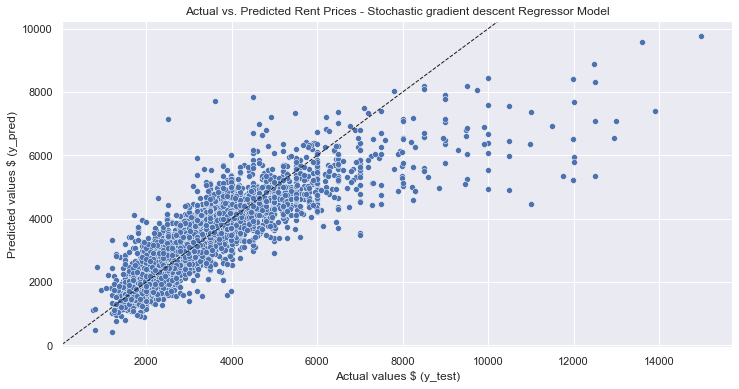

In [221]:
pred_scatterplot(y_pred_sgd, y_test, 'Stochastic gradient descent Regressor')

The model is predicting lower prices for a listing than the actual price as prices increase.
Let's look into the proportions of residual distribution. Define a low residual as one where the model has closely predicted the listing price. A medium residual to be an ok prediction but off by a few hundred, and a high residual as a predicted value that wouldn't help inform the user. 

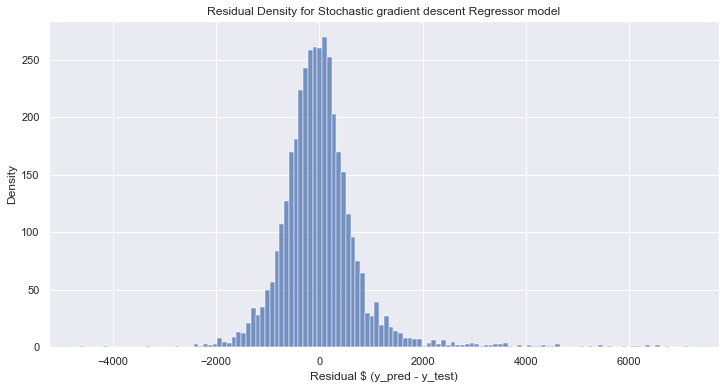

In [222]:
residual_barplot(y_pred_sgd, y_test, 'Stochastic gradient descent Regressor')

In [150]:
# Define low, med, high residuals
X_test_size = X_test.shape[0]

low_residual = 100
med_residual = 500
high_residual = 1000

# Also useful to compare percentages of the listing price
low_residual_percent = 0.15

# Residual = predicted - actual list price
residual = pd.DataFrame(y_test - y_pred_sgd)

residual.rename(columns = {'listing_price':'price_residual'}, inplace = True)
residual

,price_residual
listing_id,
7542076186,1937.808370
7539611807,855.062661
7535448927,560.582449
7521659702,-415.556389
7510444514,94.825663
...,...
7530650056,124.200519
7517015863,-41.632049
7526361125,185.059432


In [151]:
residual['listing_price'] = y_test
residual['residual_percent'] = residual['price_residual']/residual['listing_price']
residual['residual_category'] = np.where(np.abs(residual['residual_percent'])<low_residual_percent, 'Within_15_percent', 'More_than_15_percent')
# Drop duplicated index
# residual = residual.groupby(residual.index).first()
residual

,price_residual,listing_price,residual_percent,residual_category
listing_id,,,,
7542076186,1937.808370,7000,0.276830,More_than_15_percent
7539611807,855.062661,4500,0.190014,More_than_15_percent
7535448927,560.582449,3751,0.149449,Within_15_percent
7521659702,-415.556389,2400,-0.173148,More_than_15_percent
7510444514,94.825663,1850,0.051257,Within_15_percent
...,...,...,...,...
7530650056,124.200519,2000,0.062100,Within_15_percent
7517015863,-41.632049,4100,-0.010154,Within_15_percent
7526361125,185.059432,3750,0.049349,Within_15_percent


Text(0.5, 1.0, 'Residual Density as a proportion of listing price for Linear Regression')

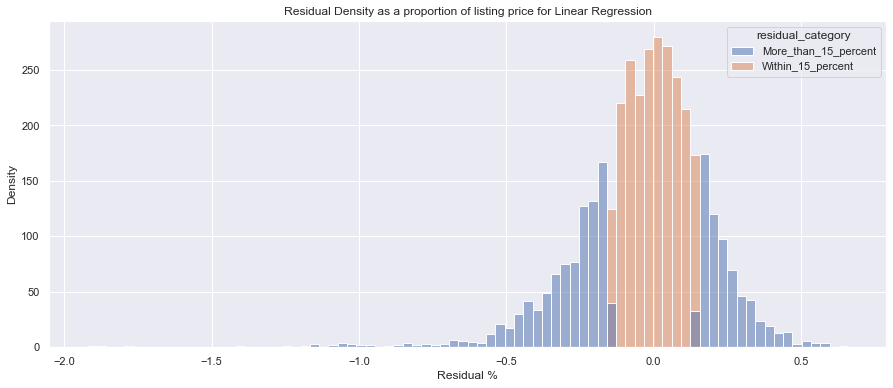

In [152]:
# Plot the distribution of residuals as a percentage
sns.set(rc={"figure.figsize":(15, 6)})
s = sns.histplot(data = residual, x='residual_percent', hue='residual_category')
plt.ylabel('Density')
plt.xlabel('Residual %')
plt.title('Residual Density as a proportion of listing price for Linear Regression')

The long left tail in the residual plot suggets the model is predicting higher values than what is actually listed as the rental price. This could be because the model is identifying good deals where the unit is being rented for a price below market value. This information could be very informative to renters who are in the rental market.

In [153]:
residual[residual['residual_percent'] < -1]

,price_residual,listing_price,residual_percent,residual_category
listing_id,,,,
7541338934,-4109.687595,3600,-1.141580,More_than_15_percent
7542681221,-2073.308046,1900,-1.091215,More_than_15_percent
7540005591,-1833.929710,1599,-1.146923,More_than_15_percent
7537010540,-1925.499796,1817,-1.059714,More_than_15_percent
7538056181,-1242.137694,1200,-1.035115,More_than_15_percent
7548761491,-2385.927330,2270,-1.051069,More_than_15_percent
7537244081,-1853.777679,1817,-1.020241,More_than_15_percent
7511856588,-2138.958385,1200,-1.782465,More_than_15_percent
7513649989,-1594.811685,1284,-1.242065,More_than_15_percent


In [154]:
# Look at the high_residual rows
index_of_interest_high = residual[(residual['price_residual'] > high_residual) | (residual['price_residual'] < -high_residual)].index
print(f'Results for X_test with missing square footage values imputed:')
print(f'There are {len(index_of_interest_high)} rows that have residuals greater than {high_residual} between actual and predicted price, which is {(len(index_of_interest_high)/X_test_size)*100:.1f}% of all rows')

# Look at the med_residual rows
index_of_interest_med = residual[(residual['price_residual'] < med_residual) & (residual['price_residual'] > -med_residual)].index
print(f'There are {len(index_of_interest_med)} rows that have residuals less than {med_residual} between actual and predicted price, which is {(len(index_of_interest_med)/X_test_size)*100:.1f}% of all rows')

# Look at the low_residual rows
index_of_interest_low = residual[(residual['price_residual'] > -low_residual) & (residual['price_residual'] < low_residual)].index
print(f'There are {len(index_of_interest_low)} rows that have residuals less than {low_residual} between actual and predicted price, which is {(len(index_of_interest_low)/X_test_size)*100:.1f}% of all rows')


Results for X_test with missing square footage values imputed:
There are 471 rows that have residuals greater than 1000 between actual and predicted price, which is 12.1% of all rows
There are 2459 rows that have residuals less than 500 between actual and predicted price, which is 63.0% of all rows
There are 571 rows that have residuals less than 100 between actual and predicted price, which is 14.6% of all rows


In [155]:
# Calculate the same comparison for predicted price within % of actual price
# Within 20%
index_of_interest_20 = residual[(residual['residual_percent'] > 0.2) | (residual['residual_percent'] < -0.2)].index
print(f'There are {X_test_size - len(index_of_interest_20)} rows that have residuals less than 20% between actual and predicted price, which is {((X_test_size - len(index_of_interest_20))/X_test_size)*100:.1f}% of all rows in the test set')

# Within 10%
index_of_interest_10 = residual[(residual['residual_percent'] > 0.1) | (residual['residual_percent'] < -0.1)].index
print(f'There are {X_test_size - len(index_of_interest_10)} rows that have residuals less than 10% between actual and predicted price, which is {((X_test_size - len(index_of_interest_10))/X_test_size)*100:.1f}% of all rows in the test set')



There are 2796 rows that have residuals less than 20% between actual and predicted price, which is 71.6% of all rows in the test set
There are 1640 rows that have residuals less than 10% between actual and predicted price, which is 42.0% of all rows in the test set


In [156]:
# Get index of rows of interest, where residual is greater than a residual percentage of 15%
listing_ids_residuals = residual[residual['residual_category'] == 'More_than_15_percent']
listing_ids_residuals

,price_residual,listing_price,residual_percent,residual_category
listing_id,,,,
7542076186,1937.808370,7000,0.276830,More_than_15_percent
7539611807,855.062661,4500,0.190014,More_than_15_percent
7521659702,-415.556389,2400,-0.173148,More_than_15_percent
7530324307,-490.826169,2550,-0.192481,More_than_15_percent
7535934478,-1631.074900,3500,-0.466021,More_than_15_percent
...,...,...,...,...
7530692864,-1019.954848,3995,-0.255308,More_than_15_percent
7544617975,-486.368863,1375,-0.353723,More_than_15_percent
7521443400,909.018939,4950,0.183640,More_than_15_percent


In [157]:
# Look at residuals as a percentage of listing price
residuals_df = pd.merge(listing_ids_residuals, df_nonscaled, on = 'listing_id', how = 'left')

residuals_df['residual_percent'] = residuals_df['residual_percent']*100

# Only look at rows that have listing_sqft i.e. it was not imputed
residuals_df = residuals_df[residuals_df.listing_sqft.notnull()]

In [158]:
residuals_df

,price_residual,listing_price_x,residual_percent,residual_category,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,...,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO,price_per_sqft,listing_price_y
listing_id,,,,,,,,,,,,,,,,,,,,,
7542076186,1937.808370,7000,27.682977,More_than_15_percent,1648.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.539241,7000.0
7539611807,855.062661,4500,19.001392,More_than_15_percent,970.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.286786,4500.0
7521659702,-415.556389,2400,-17.314850,More_than_15_percent,470.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.842439,2400.0
7530324307,-490.826169,2550,-19.248085,More_than_15_percent,1100.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.888059,2550.0
7535934478,-1631.074900,3500,-46.602140,More_than_15_percent,2604.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.175682,3500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7530692864,-1019.954848,3995,-25.530785,More_than_15_percent,1360.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.305134,3995.0
7544617975,-486.368863,1375,-35.372281,More_than_15_percent,470.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.705520,1375.0
7521443400,909.018939,4950,18.364019,More_than_15_percent,1083.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.922444,4950.0


[Text(0.5, 1.0, 'Price residual by number of bedrooms')]

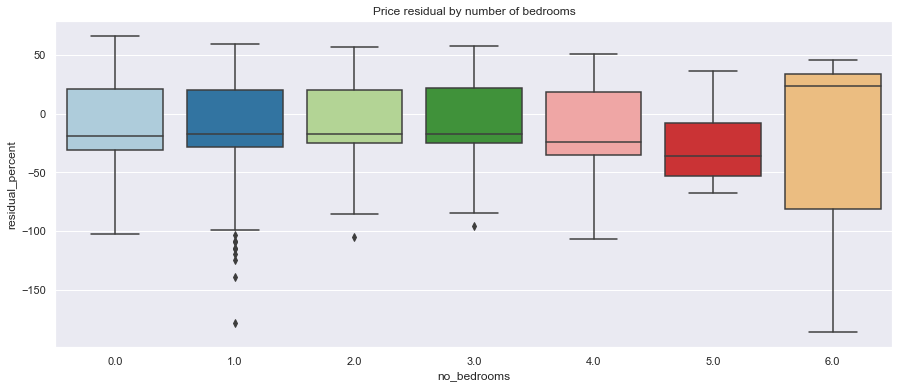

In [159]:
# Plot the residuals on a boxplot, grouped by number of bedrooms
sns.boxplot(data=residuals_df, y ='residual_percent',x='no_bedrooms', palette=sns.color_palette('Paired')).set(title='Price residual by number of bedrooms')


The prediction accuracy is the worst for 1 bedroom places. This could be because they are the most common listing size. Another way to segment the listings would be by square footage. The average square footage sizes are:
* Studio apartments: 400-600 sqft
* 1 bedroom apartments: 700-800 sqft
* 2 bedroom apartments: 900- 1200 sqft
* 3+ bedroom apartments: 1300 sqft+

[Text(0.5, 1.0, 'Price residual by listing square footage')]

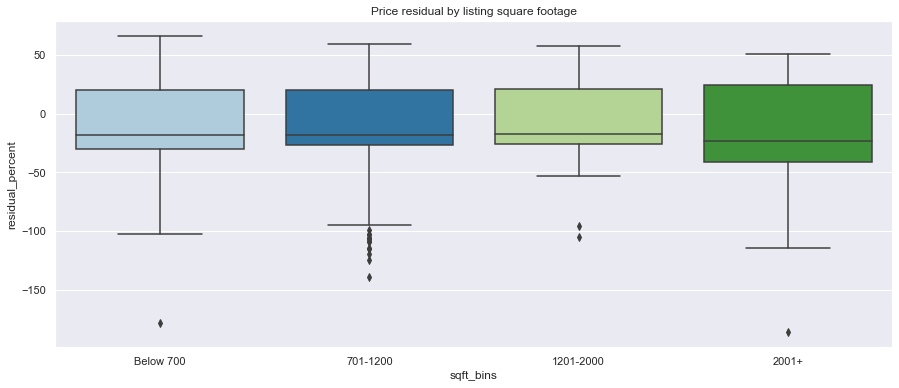

In [160]:
# Plot the residuals on a boxplot, grouped by bins of square footage values
bins = [0, 700, 1200, 2000, float('Inf')]
bin_labels = ['Below 700','701-1200','1201-2000','2001+']
residuals_df['sqft_bins'] = pd.cut(residuals_df['listing_sqft'], bins=bins, labels=bin_labels)
sns.boxplot(data=residuals_df, y ='residual_percent',x='sqft_bins', palette=sns.color_palette('Paired')).set(title='Price residual by listing square footage')


This plot suggests the high residuals appear in the lower square footage listings.

In [161]:
# Look at residuals greater than 50%
residuals_50 = residuals_df[(residuals_df['residual_percent'] > 0.5) | (residuals_df['residual_percent'] < -0.5)]
print(f'There are {residuals_50.shape[0]} rows that had residuals greater than 50%')
residuals_50.head()

There are 1597 rows that had residuals greater than 50%


,price_residual,listing_price_x,residual_percent,residual_category,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,...,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO,price_per_sqft,listing_price_y,sqft_bins
listing_id,,,,,,,,,,,,,,,,,,,,,
7542076186,1937.808370,7000,27.682977,More_than_15_percent,1648.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.539241,7000.0,1201-2000
7539611807,855.062661,4500,19.001392,More_than_15_percent,970.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.286786,4500.0,701-1200
7521659702,-415.556389,2400,-17.314850,More_than_15_percent,470.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.842439,2400.0,Below 700
7530324307,-490.826169,2550,-19.248085,More_than_15_percent,1100.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.888059,2550.0,701-1200
7535934478,-1631.074900,3500,-46.602140,More_than_15_percent,2604.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.175682,3500.0,2001+


[Text(0.5, 1.0, 'Distribution of residuals greater than 50% by square footage')]

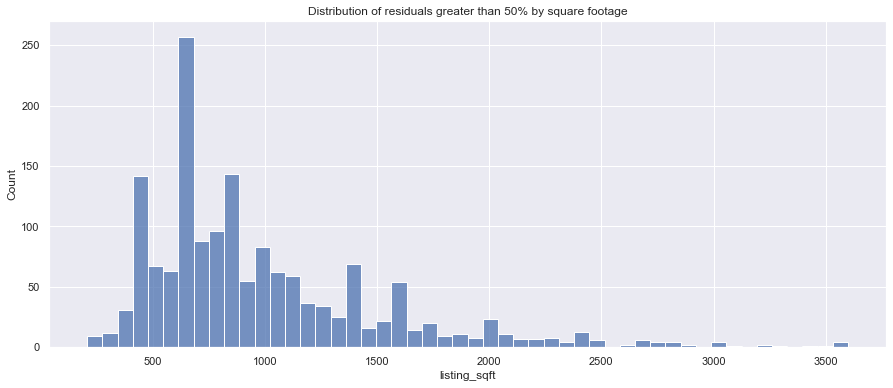

In [162]:
# Plot the price residual distribution of square footage as a histogram
sns.histplot(data=residuals_50, x="listing_sqft", bins=50).set(title='Distribution of residuals greater than 50% by square footage')


This looks like a similar distribution to the plot from EDA for the square footage feature, and there is no obvious cluster of listings that differs from the population distribution. 

[Text(0.5, 1.0, 'Distribution of residuals over 50%')]

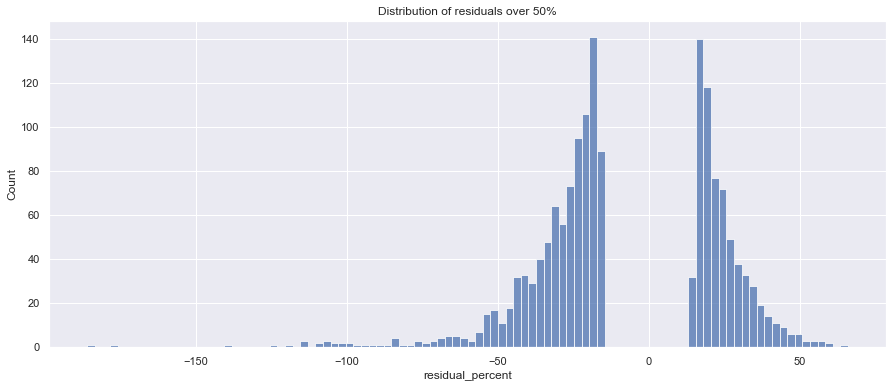

In [163]:
# Plot the distribution of residuals over 50%
sns.histplot(data=residuals_50, x="residual_percent", bins=100).set(title='Distribution of residuals over 50%')


There are more residuals on the left hand side, which suggest the listings are below the predicted market price.

In [164]:
# Plot residuals by neighborhood to see if there is a relationship
nh_df = pd.DataFrame(y_test)
nh_df['predicted_price'] = y_pred_sgd

nh_df = pd.merge(nh_df, df, on = "listing_id", how = "left")
nh_df = nh_df[['listing_nh','listing_price_x','predicted_price']]
nh_df['price_diff'] = nh_df['listing_price_x'] - nh_df['predicted_price']
nh_df['percentage'] = nh_df['price_diff']/nh_df['listing_price_x']
nh_df

# Calculate MAPE 
nh_mape = nh_df.groupby(['listing_nh']).percentage.apply(lambda c: c.abs().mean())*100
nh_mape.sort_values(ascending=False)

# Look at distribution of neighborhoods in the X_train set
nh_size = X_train_preprocess['listing_nh'].value_counts()
nh_size_df = pd.DataFrame({'nh_distribution':nh_size})

# Combine into a df for comparison
nh_df_plot = pd.DataFrame({'nh_mape':nh_mape})
nh_dist = nh_df_plot.merge(nh_size_df, left_index=True, right_index=True, how='left').reset_index()
nh_dist = nh_dist.sort_values(['nh_distribution'], ascending=True)
nh_dist

,listing_nh,nh_mape,nh_distribution
38,millbrae,19.014213,1.0
9,brentwood / oakley,43.197210,2.0
58,redwood shores,1.673231,4.0
18,east palo alto,9.365612,5.0
71,visitacion valley,5.063354,8.0
...,...,...,...
47,oakland lake merritt / grand,13.001167,366.0
0,SOMA / south beach,19.061016,399.0
6,berkeley,19.824993,438.0
63,san carlos,4.888643,NaN


There aren't enough data points in some of the smaller neighborhoods, which explains why the MAPE of those neighborhoods are so high. To improve the model, it could make sense to split the neighborhoods into different models.

<a id="8"></a> 
## 3. Random Forest Regressor
Train a Random Forest Regressor model using Grid Search with 5 cross validation folds. 

In [165]:
param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6]
}


model_rf = train_model(RandomForestRegressor(), param_grid, 5, 'neg_mean_absolute_percentage_error', X_train, y_train)
metrics_dict_rf = evaluate_model(model_rf, X_test, y_test)
y_pred_rf = model_rf.predict(X_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


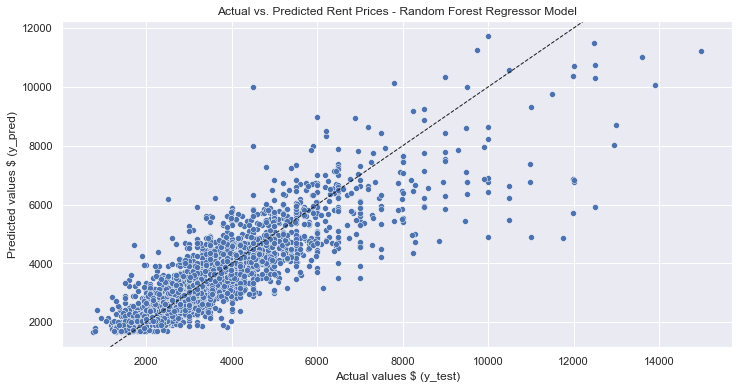

In [166]:
pred_scatterplot(y_pred_rf, y_test, 'Random Forest Regressor')

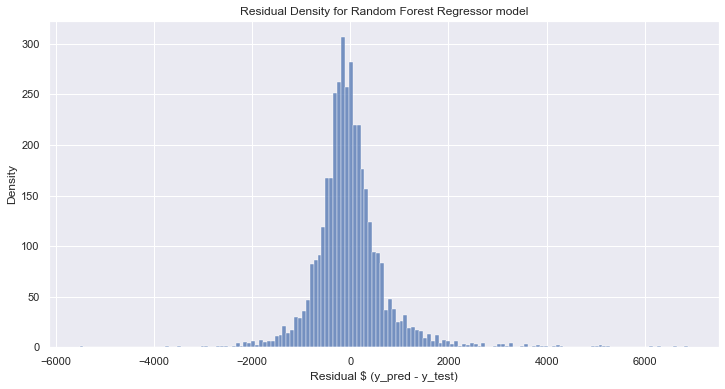

In [167]:
residual_barplot(y_pred_rf, y_test, 'Random Forest Regressor')

These residual plots show that as listing price increases, the residuals get bigger, with the predicted value often being lower than the actual value.

<a id="9"></a> 
## 4. XGBoost Regressor
Train a XGBoost model using Grid Search with 5 cross validation folds. 

In [168]:
param_grid = {'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200],
             'learning_rate' : [0.001, 0.01, 0.1]}

model_xgb = train_model(xgb.XGBRegressor(), param_grid, 5, 'neg_mean_absolute_percentage_error', X_train, y_train)
metrics_dict_xgb = evaluate_model(model_xgb, X_test, y_test)
y_pred_xgb = model_xgb.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


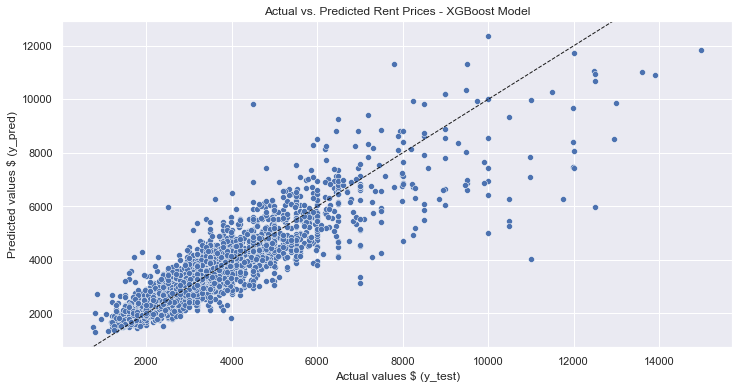

In [169]:
pred_scatterplot(y_pred_xgb, y_test, 'XGBoost')

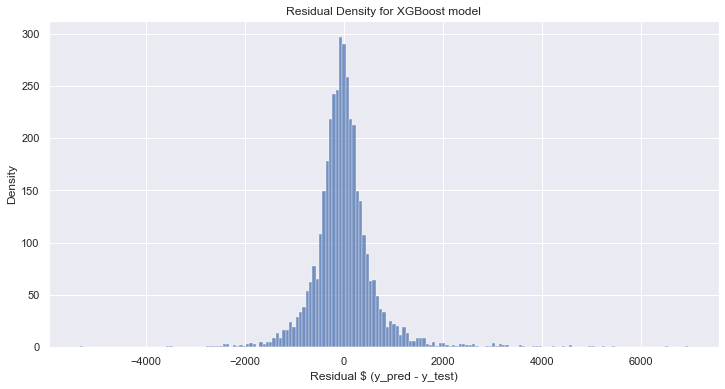

In [170]:
residual_barplot(y_pred_xgb, y_test, 'XGBoost')

Again, these residual plots show that as listing price increases, the residuals get bigger, with the predicted value often being lower than the actual value.

<a id="10"></a> 
## 5. LGBM Regressor
Train a LGBM model using Grid Search with 5 cross validation folds. 

In [171]:
param_grid = {'n_estimators':[10, 50, 100, 500],
            'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
             'subsample':[0.5, 0.7, 1.0],
             'max_depth': [2, 3, 4, 5, 6]}

model_lgbm = train_model(lightgbm.LGBMRegressor(), param_grid, 5, 'neg_mean_absolute_percentage_error', X_train, y_train)
metrics_dict_lgb = evaluate_model(model_lgbm, X_test, y_test)
y_pred_lgb = model_lgbm.predict(X_test)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


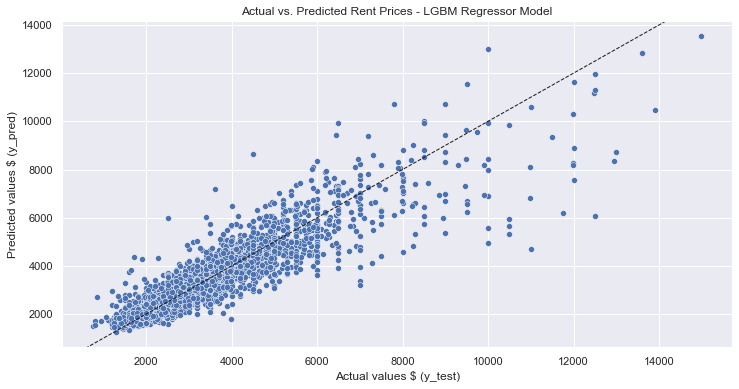

In [172]:
pred_scatterplot(y_pred_lgb, y_test, 'LGBM Regressor')

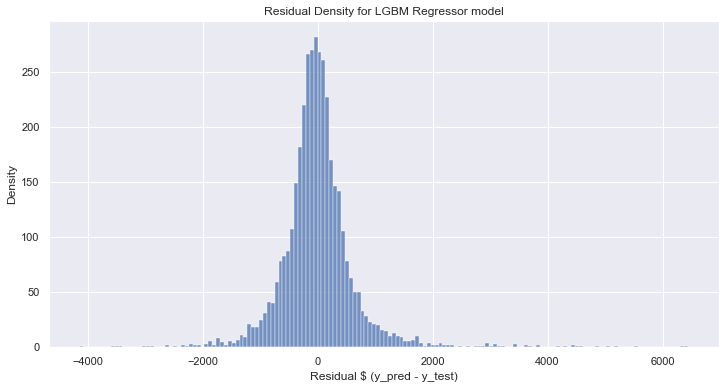

In [173]:
residual_barplot(y_pred_lgb, y_test, 'LGBM Regressor')

Again, these residual plots show that as listing price increases, the residuals get bigger, with the predicted value often being lower than the actual value. There is a longer right tail as shown on the bar graph. 

<a id="11"></a> 
## 6. Piecewise SGDR model by number of bedrooms
Train a piecewise model using Grid Search with 5 cross validation folds. 
Split the dataset into subsets based on the number of bedrooms to introduce some nonlinearity to the SGDR model. The frequency of each bedroom count is shown below:

In [174]:
#Add a column to the scaled df with number of bedrooms
X_train_piecewise = X_train.copy()
X_test_piecewise = X_test.copy()
X_train_piecewise['Bedroom_count'] = X_train_preprocess.no_bedrooms
X_test_piecewise['Bedroom_count'] = X_test_preprocess.no_bedrooms

In [175]:
# Calculate how many of each bedrooms using unscaled data
X_train_piecewise.Bedroom_count.value_counts()

2    3091
1    2927
3    1469
0     963
4     535
5     107
6      22
Name: Bedroom_count, dtype: int64

### Create 5 piecewise models by subsetting the data into 0, 1, 2, 3, 4-6 bedrooms 

In [176]:
class PiecewiseEstimator(BaseEstimator, RegressorMixin):

    def fit(self, X, y):
        self.models = []
        for X_partitioned in self._partition(X):
            y_partitioned = y.loc[X_partitioned.index]
                        
            # Fit the model
            param_grid = { 
                'alpha': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.25],
                'max_iter': [1500]
            }

            model = train_model(SGDRegressor(penalty='elasticnet'), param_grid, 5, 'neg_mean_absolute_percentage_error', X_partitioned, y_partitioned)
            self.models.append(model)
        return self
    
    def predict(self, X):
        y = np.zeros((X.shape[0]))
        for (X_partitioned, model) in zip(self._partition(X), self.models):
            y_partitioned = model.predict(X_partitioned)    
            for i, listing_id in enumerate(X_partitioned.index):
                y[X.index.get_loc(listing_id)] = y_partitioned[i]
        return y
        
    def _partition(self, X):
        bedroom_list = [[0],[1],[2],[3],[4,5,6]]
        X_partitions = [X[X.Bedroom_count.isin(room)].drop('Bedroom_count', axis=1) for room in bedroom_list]
        
        assert(sum([X_partition.shape[0] for X_partition in X_partitions]) == X.shape[0])
        return X_partitions

In [177]:
model_piecewise = PiecewiseEstimator().fit(X_train_piecewise, y_train)
metrics_dict_piecewise = evaluate_model(model_piecewise, X_test_piecewise, y_test)
y_pred_piecewise = model_piecewise.predict(X_test_piecewise)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


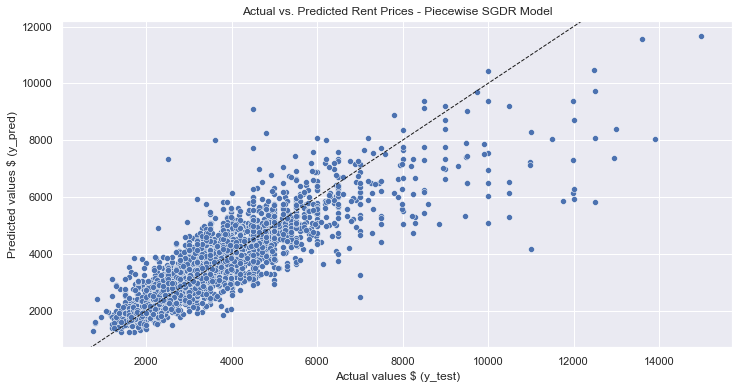

In [178]:
pred_scatterplot(y_pred_piecewise, y_test, 'Piecewise SGDR')

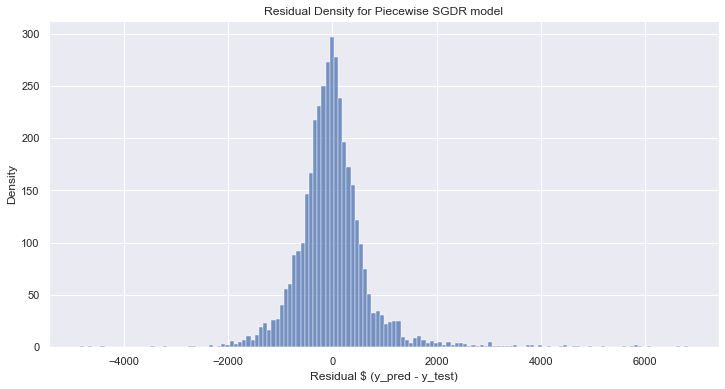

In [179]:
residual_barplot(y_pred_piecewise, y_test, 'Piecewise SGDR')

These residual plots show that as listing price increases, the residuals get bigger, with the predicted value often being lower than the actual value. There is also a longer right tail as shown on the bar graph.

<a id="12"></a> 
## 7. Piecewise SGDR model by neighborhood
Train separate SGDR models using Grid Search with 5 cross validation folds for each neighborhood that has more than 100 listings. 

In [180]:
# Create copies of the training and testing sets
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()
df_1 = df.copy()

In [181]:
# Join neighborhood column labels to preprocessed dataframe
X_train_1 = X_train_1.merge(df_1.listing_nh, left_index=True, right_index=True, how='left')
X_test_1 = X_test_1.merge(df_1.listing_nh, left_index=True, right_index=True, how='left')

In [182]:
# Check size of each neighborhood, are there any smaller than 100 listings?
training_count = X_train_1.listing_nh.value_counts()
# Select neighborhoods that are greater than 100 counts
training_count = training_count[training_count>100]
training_count

berkeley                              438
SOMA / south beach                    399
oakland lake merritt / grand          366
mission district                      294
dublin / pleasanton / livermore       290
fremont / union city / newark         280
alameda                               273
nob hill                              239
oakland east                          238
san mateo                             225
redwood city                          221
palo alto                             207
oakland downtown                      202
walnut creek                          196
pacific heights                       188
concord / pleasant hill / martinez    184
hayward / castro valley               183
marina / cow hollow                   178
sunset / parkside                     173
mountain view                         149
daly city                             144
russian hill                          144
pittsburg / antioch                   143
lower nob hill                    

In [183]:
len(training_count)

36

In [184]:
# Percentage of X_train this covers
sum(training_count)/len(X_train_1) * 100
# The remaining 20% of smaller neighborhoods where there isn't enough data can use the regular base model.

76.16853192890059

In [185]:
# List of neighborhoods to loop over
neighborhood_model_list = list(training_count.index)

In [186]:
# Train SGDR model for each neighborhood in the neighborhood_model_list
param_grid = { 
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.25],
    'max_iter': [1500]
}
y_test_sgd_nh = []
y_pred_sgd_nh = []
metrics_dict_sgd_nh = []

for nh in neighborhood_model_list:
    # Subset training and testing with listings in the neighborhood_model_list
    X_train_2 = X_train_1[X_train_1.listing_nh == nh].copy()
    X_test_2 = X_test_1[X_test_1.listing_nh == nh].copy()

    # Drop the listing_nh column
    X_train_2.drop('listing_nh', axis=1, inplace=True)
    X_test_2.drop('listing_nh', axis=1, inplace=True)
    
    # Subset the corresponding y_train, y_test
    y_train_2 = y_train[X_train_2.index]
    y_test_2 = y_test[X_test_2.index]
    
    # Model
    model_sgd = train_model(SGDRegressor(penalty='elasticnet'), param_grid, 5, 'neg_mean_absolute_percentage_error', X_train_2, y_train_2)
    metrics_dict_sgd_nh.append(evaluate_model(model_sgd, X_test_2, y_test_2))
    y_test_sgd_nh.append(y_test_2)
    y_pred_sgd_nh.append(model_sgd.predict(X_test_2))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [187]:
# Overall accuracy metric for this neighborhood model
metrics_nh = pd.DataFrame(metrics_dict_sgd_nh, index= neighborhood_model_list)
metrics_nh = metrics_nh[['MAPE score %']]
metrics_nh

,MAPE score %
berkeley,16.574831
SOMA / south beach,16.596814
oakland lake merritt / grand,13.352151
mission district,14.004523
dublin / pleasanton / livermore,10.829266
fremont / union city / newark,7.494786
alameda,12.991926
nob hill,12.873435
oakland east,14.797512
san mateo,13.331634


In [188]:
# Average MAPE score across all neighborhoods
metrics_nh.describe()

,MAPE score %
count,36.000000
mean,13.336599
std,2.868672
min,7.479322
25%,11.624904
50%,13.338156
75%,14.869339
max,19.724321


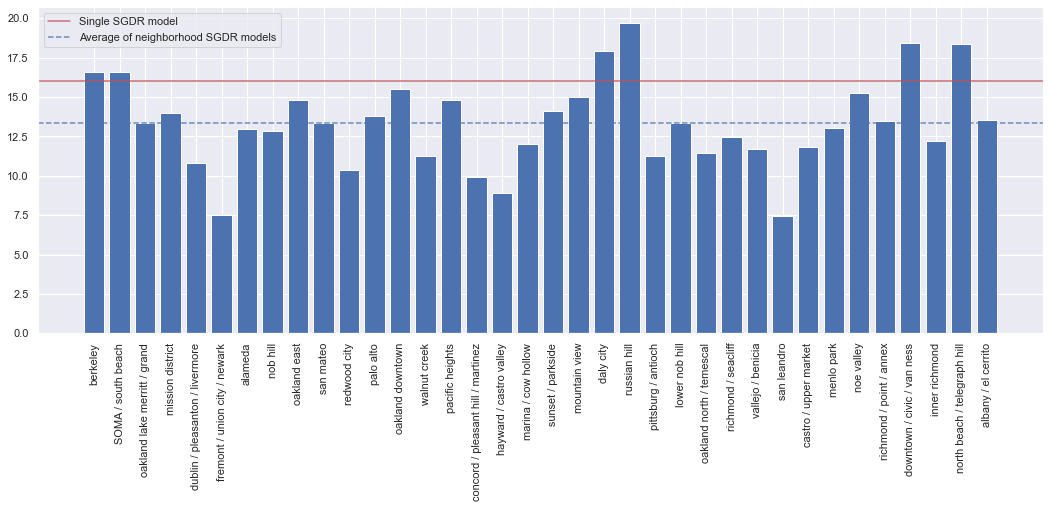

In [220]:
# Plot accuracy metric for each neighborhood vs. the SGDR model for all neighborhood
plt.figure(figsize=(18,6))
plt.bar(x=metrics_nh.index, height=metrics_nh['MAPE score %'])
plt.axhline(y = metrics_dict_sgd['MAPE score %'], color = 'r', linestyle = '-', alpha=0.8, label='Single SGDR model')
plt.axhline(y = metrics_nh['MAPE score %'].mean(), color = 'b', linestyle = '--', alpha=0.8, label='Average of neighborhood SGDR models')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Overall, the individual neighborhood SGDR models produced better accuracy results than the single SGDR model. Some neighborhoods performed much better such as Fremont, Hayward, San Leandro. Other neighborhoods performed worse than the single SGDR model such as Russian Hill, downtown/civic/van ness or North Beach.

In [190]:
best_performing_nh = metrics_nh['MAPE score %'].idxmin()
best_performing_nh_mape = metrics_nh['MAPE score %'].min()
print(f'The best performing neighborhood was {best_performing_nh} with a MAPE % of {best_performing_nh_mape:.3}')

worst_performing_nh = metrics_nh['MAPE score %'].idxmax()
worst_performing_nh_mape = metrics_nh['MAPE score %'].max()
print(f'The worst performing neighborhood was {worst_performing_nh} with a MAPE % of {worst_performing_nh_mape:.3}')

The best performing neighborhood was san leandro with a MAPE % of 7.48
The worst performing neighborhood was russian hill with a MAPE % of 19.7


In [191]:
idx_best = neighborhood_model_list.index(best_performing_nh)
idx_worst = neighborhood_model_list.index(worst_performing_nh)

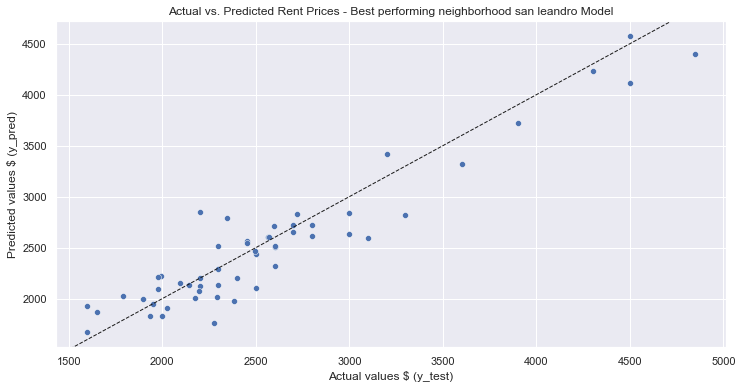

In [192]:
# Plot the residuals of the best neighborhood compared to the single SGDR model
pred_scatterplot(y_pred_sgd_nh[idx_best], y_test_sgd_nh[idx_best], f'Best performing neighborhood {neighborhood_model_list[idx_best]}')


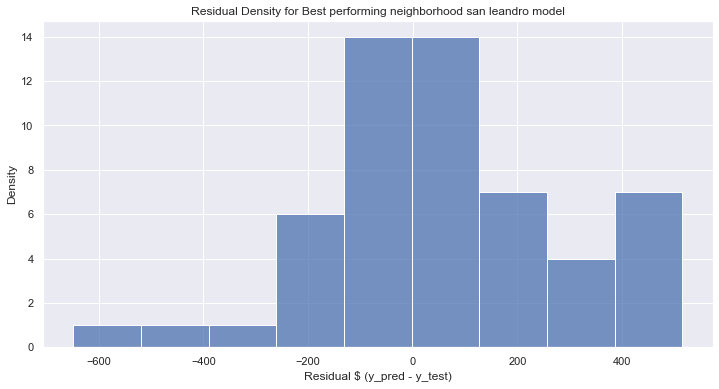

In [193]:
residual_barplot(y_pred_sgd_nh[idx_best], y_test_sgd_nh[idx_best], f'Best performing neighborhood {neighborhood_model_list[idx_best]}')

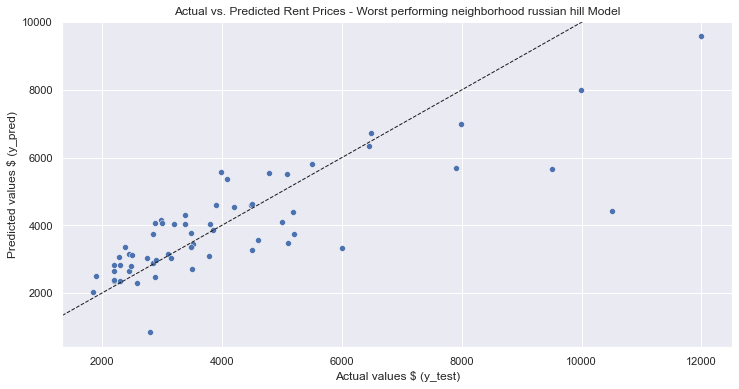

In [194]:
# Plot the worst performing neighborhood
pred_scatterplot(y_pred_sgd_nh[idx_worst], y_test_sgd_nh[idx_worst], f'Worst performing neighborhood {neighborhood_model_list[idx_worst]}')

This scatterplot shows the predicted values are much lower than actual listed values for listing prices above 5000 dollars/month, suggesting there is nonlinearity in the model/outliers.

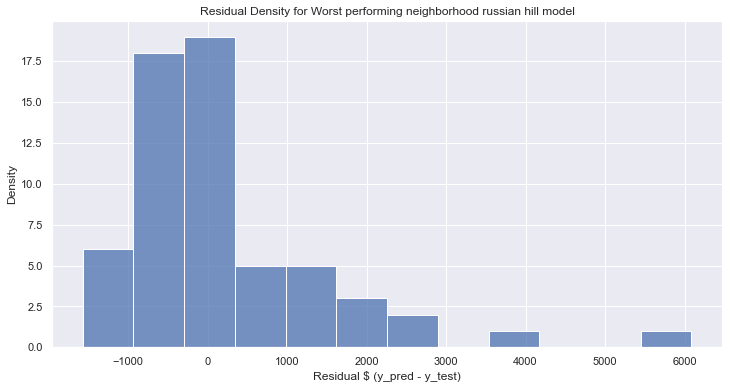

In [195]:
residual_barplot(y_pred_sgd_nh[idx_worst], y_test_sgd_nh[idx_worst], f'Worst performing neighborhood {neighborhood_model_list[idx_worst]}')

In [196]:
# Train XGBoost model for each neighborhood in the neighborhood_model_list
param_grid = {'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200],
             'learning_rate' : [0.001, 0.01, 0.1]}

y_pred_xgb_nh = []
metrics_dict_xgb_nh = []

for nh in neighborhood_model_list:
    # Subset training and testing with listings in the neighborhood_model_list
    X_train_2 = X_train_1[X_train_1.listing_nh == nh].copy()
    X_test_2 = X_test_1[X_test_1.listing_nh == nh].copy()

    # Drop the listing_nh column
    X_train_2.drop('listing_nh', axis=1, inplace=True)
    X_test_2.drop('listing_nh', axis=1, inplace=True)
    
    # Subset the corresponding y_train, y_test
    y_train_2 = y_train[X_train_2.index]
    y_test_2 = y_test[X_test_2.index]
    
    # Model
    model_xgb = train_model(xgb.XGBRegressor(), param_grid, 5, 'neg_mean_absolute_percentage_error', X_train_2, y_train_2)
    metrics_dict_xgb_nh.append(evaluate_model(model_xgb, X_test_2, y_test_2))
    y_pred_xgb_nh.append(model_xgb.predict(X_test_2))
    

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 

In [197]:
metrics_dict_sgd_nh_overall = {'Model':'Piecewise neighborhood model',
                               'R2 score': np.mean([model['R2 score'] for model in metrics_dict_sgd_nh]),
                                'RMSE score': np.mean([model['RMSE score'] for model in metrics_dict_sgd_nh]),
                                'MAE score': np.mean([model['MAE score'] for model in metrics_dict_sgd_nh]),
                                'MAPE score %': np.mean([model['MAPE score %'] for model in metrics_dict_sgd_nh])
                              }
metrics_dict_sgd_nh_overall

{'Model': 'Piecewise neighborhood model',
 'R2 score': 0.7371520684963769,
 'RMSE score': 657.5519080839399,
 'MAE score': 441.5206762901236,
 'MAPE score %': 13.336599112950887}

In [198]:
metrics_nh_xgb = pd.DataFrame(metrics_dict_xgb_nh, index= neighborhood_model_list)
metrics_nh_xgb = metrics_nh_xgb[['MAPE score %']]
metrics_nh_xgb.describe()

,MAPE score %
count,36.000000
mean,12.990898
std,2.586197
min,7.746399
25%,11.329055
50%,13.233589
75%,14.487301
max,20.604923


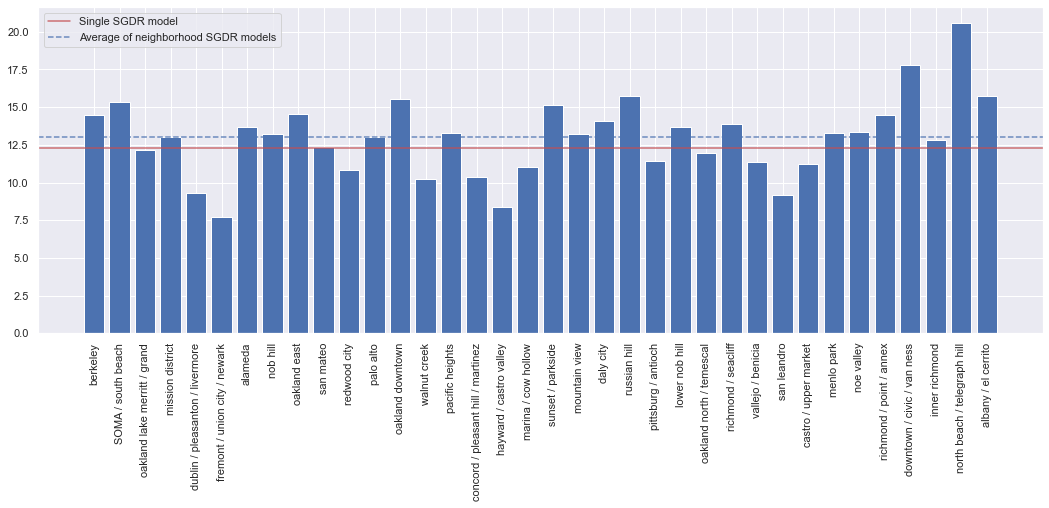

In [199]:
# Plot accuracy metric for each neighborhood vs. the XGD model for all neighborhood

plt.figure(figsize=(18,6))
plt.bar(x=metrics_nh_xgb.index, height=metrics_nh_xgb['MAPE score %'])
plt.axhline(y = metrics_dict_xgb['MAPE score %'], color = 'r', linestyle = '-', alpha=0.8, label='Single SGDR model')
plt.axhline(y = metrics_nh_xgb['MAPE score %'].mean(), color = 'b', linestyle = '--', alpha=0.8, label='Average of neighborhood SGDR models')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Overall, the individual neighborhood XGBoost models produced worse accuracy results than the single XGBoost model. This makes sense as the XGBoost model was probably making splits based on neighborhood, and the individual models were subsets of the single model but with less data (76% of training data)

<a id="13"></a> 
# Model Evaluation - test set metrics

For model metrics and evalution, choose mean absolute error (MAE) as the accuracy metric over RMSE because the data has a long right tail, so the RMSE gives a higher weight to large errors which distorts the accuracy of the model for the majority of listings. The MAE is more robust to outliers than RMSE, and as seen in the EDA portion, in the more expensive cities such as San Francisco, Oakland, Berkeley, Menlo Park, Palo Alto, there are more price outliers.  

The MAE is a better intuitive metric for this model as it reflects on average how far off the predicted price is from the actual price, where the units are in dollars. 
The mean absolute percentage error (MAPE) is also used as a metric because comparing the percentage error is easier across cities that could have high and low listing prices. 


In [200]:
# Create a table summarizing the metrics for each machine learning model
metrics_dict_baseline['Model'] = 'Baseline Model'
metrics_dict_sgd['Model'] = 'Stochastic Gradient Descent'
metrics_dict_rf['Model'] = 'Random Forest Regressor'
metrics_dict_xgb['Model'] = 'XGBoost'
metrics_dict_lgb['Model'] = 'LGBM Regressor'
metrics_dict_piecewise['Model'] = 'Piecewise SGDR by bedrooms'

metrics_d = [metrics_dict_baseline, metrics_dict_sgd, metrics_dict_rf, metrics_dict_xgb, metrics_dict_lgb, metrics_dict_piecewise, metrics_dict_sgd_nh_overall]
score_tab = pd.DataFrame(metrics_d)
score_tab

,Model,R2 score,RMSE score,MAE score,MAPE score %
0,Baseline Model,0.598464,973.305237,656.303109,19.759573
1,Stochastic Gradient Descent,0.710415,826.561128,530.573053,16.043650
2,Random Forest Regressor,0.761220,750.560409,482.582773,14.585598
3,XGBoost,0.809459,670.471823,416.931511,12.296808
4,LGBM Regressor,0.808822,671.592160,419.693998,12.355998
5,Piecewise SGDR by bedrooms,0.761734,749.752559,473.805561,14.114936
6,Piecewise neighborhood model,0.737152,657.551908,441.520676,13.336599


## Conclusion:
The XGBoost and LGBM Regressor both performed well as shown in the performance metrics table. An average prediction error of 12% is pretty good for one model on a wide range of listing sizes and locations. Since the ultimate objective of this model is to predict the rental price for the test data, the best model is the XGBoost Regressor.

The piecewise SGDR models showed an improvement in the linear model, especially training separate models by neighborhood. If there was more data, the smaller neighborhoods could have been trained too, but defaulting to the overall model for smaller neighborhoods works ok too. 

Text(0.5, 1.0, 'Residual Density by Model')

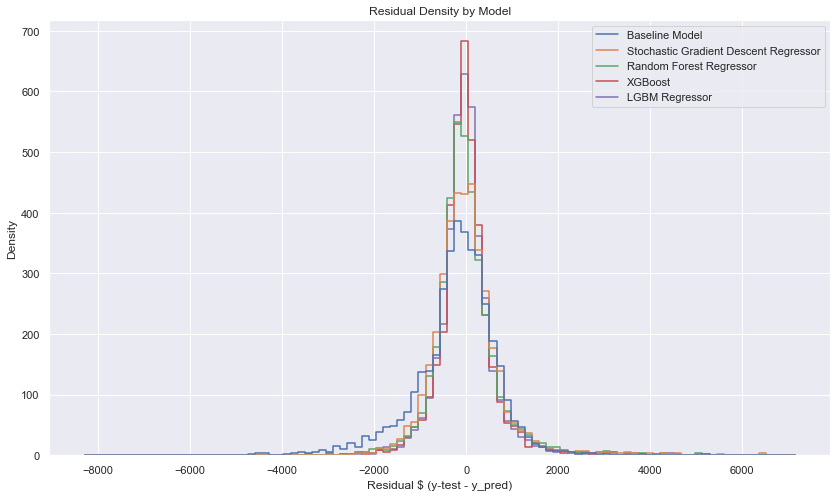

In [219]:
d = {"Baseline Model": y_test-y_pred_baseline, "Stochastic Gradient Descent Regressor": y_test-y_pred_sgd, "Random Forest Regressor": y_test-y_pred_rf, "XGBoost": y_test-y_pred_xgb, "LGBM Regressor": y_test-y_pred_lgb}
models_pred = pd.DataFrame(d)

# Create a histplot of the residual densities comparing the performance of each of the models
# Exclude the piecewise models as they are an extension of the SGDR model
sns.set(rc={"figure.figsize":(14, 8)})
s = sns.histplot(models_pred, bins=100, element="step", fill=False)
plt.ylabel('Density')
plt.xlabel('Residual $ (y-test - y_pred)')
plt.title('Residual Density by Model')


The baseline model performed the worst, with the lowest density around residual = 0 and higher density in the left tail of the residual plot, indicating the model is predicting too high.
The XGBoost model performed the best, with the highest density around residual = 0.

<a id="14"></a> 
# Interpretability

In [202]:
# Plot the feature importances of the linear stochastic gradient descent model
import shap
pred = model_sgd.predict(X_test)
explainer = shap.Explainer(model_sgd.predict, X_test)
shap_values = explainer(X_test)
#np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()


Permutation explainer: 3907it [01:26, 40.83it/s]                                


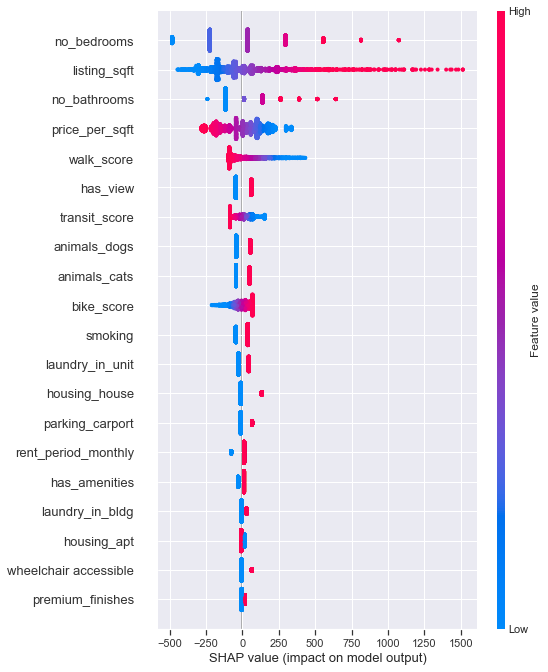

In [203]:
# Summary plot combines the feature importance with feature effects
shap.summary_plot(shap_values, X_test)

The feature 'no_bedrooms' is the most important feature, with clusters shown at each 7 options. 

The next most important feature is 'listing_sqft', and has a high Shapley value range. The points are offset in the y-axis to show the distribution of the shapley values (there is a cluster of them in the blue range suggesting most are on the low end of the range, with a long right tail of red).

In [204]:
# Now plot the feature importances of the XGBoost model

import shap
pred = model_xgb.predict(X_test, output_margin=True)
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


0.0024414062

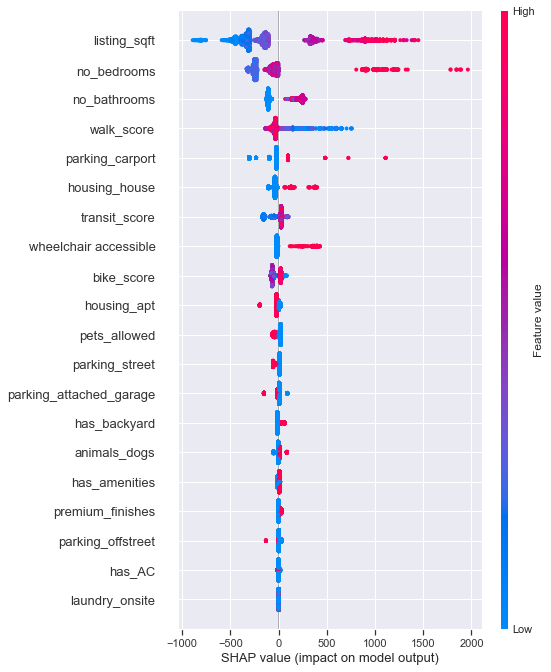

In [205]:
shap.summary_plot(shap_values, X_test)

The XGBoost summary plot looks similar to the stochastic gradient descent one, which is reassuring that the models are behaving similarly. 

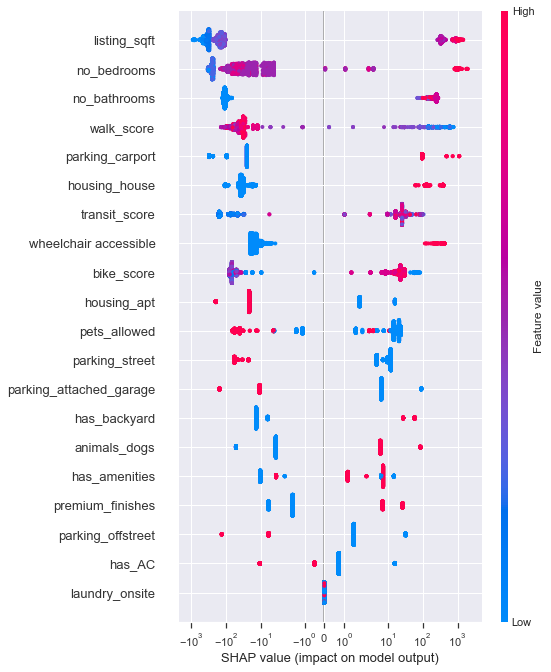

In [206]:
# Try the same plot but with a log scale to show the binary features better rather than being so close together
shap.summary_plot(shap_values, X_test, use_log_scale=True)

This shows the binary features on a better scale, such as the feature 'has_AC' has a majority of values near the SHAP value near 1

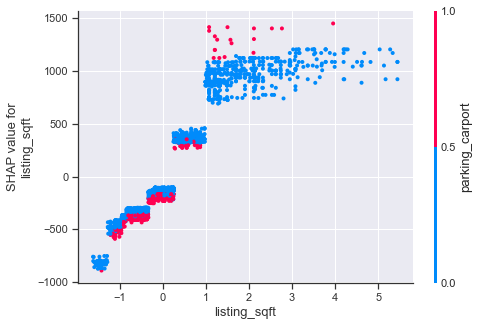

In [207]:
# Plot the relationship between 'listing_sqft' and it's next most related feature
shap.dependence_plot('listing_sqft', shap_values, X_test)

This shows that as listing_sqft increases, the binary feature parking_carport tends to have a value of 0, i.e. the property does not have a carport as a parking option. 

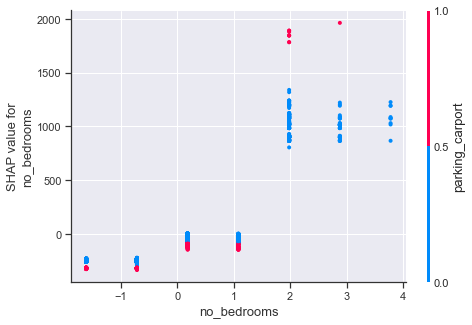

In [208]:
shap.dependence_plot('no_bedrooms', shap_values, X_test)

This dependence plot shows that as the number of bedrooms increases, so does the vertical dispersion of the interaction effects between 'no_bedrooms' and the feature 'parking_carport'.


### Feature Importance - XGBoost model

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

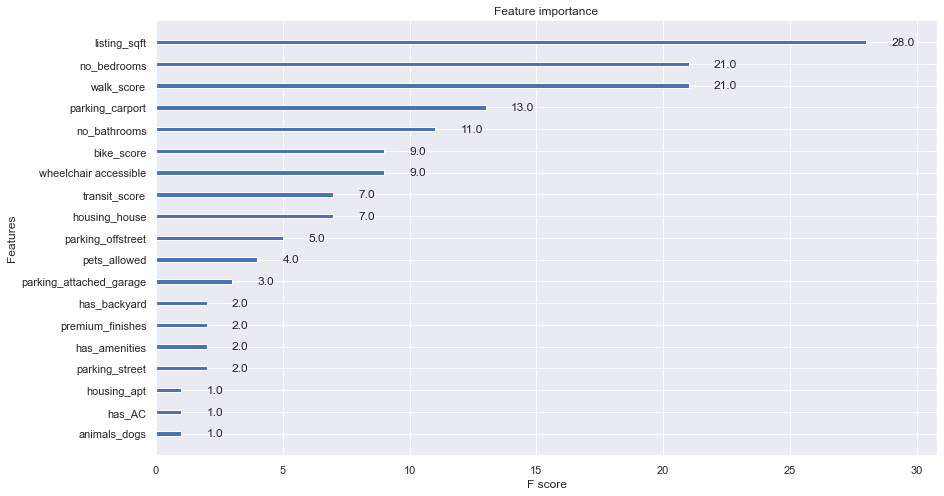

In [209]:
# Look at the feature importances using the built in XGBoost Feature Importance Plot
# plot feature importance
xgb.plot_importance(model_xgb)

The top features in the model are the size of the property i.e. square footage and number of bedrooms/bathrooms, and features to do with the location - the "expensiveness" of the neighborhood and the proximity to shops and transit.

### Feature Importance - SGDR model
Look at the linear regression model and the feature coefficients to see if they make sense:

In [210]:
coefs = pd.DataFrame(
   model_sgd.coef_,
   columns=['Coefficients'], index=X_train.columns)

coefs = coefs.sort_values(by='Coefficients', ascending=False)
coefs.head(5)

,Coefficients
no_bedrooms,289.018943
listing_sqft,277.593056
no_bathrooms,159.357010
housing_house,144.624210
has_view,106.472172


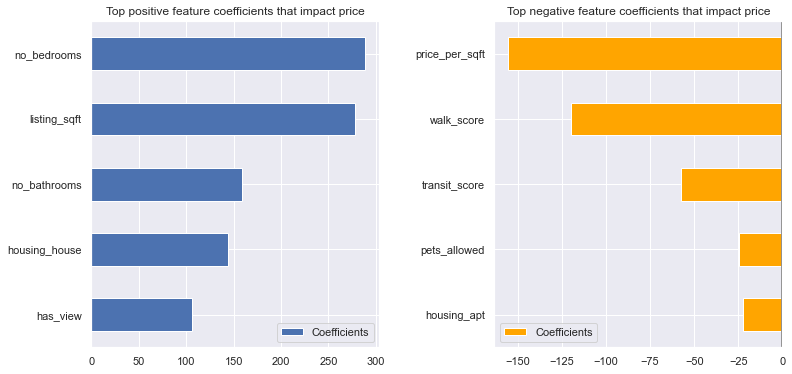

In [211]:
# Plot top positive and negative feature importances for stochastic gradient descent model
fig, (ax1, ax2) = plt.subplots(1, 2)

coefs.head(5).sort_values(by='Coefficients').plot(kind='barh', ax=ax1, figsize=(16,6))
ax1.set_title('Top positive feature coefficients that impact price')

plt.axvline(x=0, color='.5')
plt.subplots_adjust(wspace =.4)

coefs.tail(5).plot(kind='barh', ax=ax2, color = 'orange')
ax2.set_title('Top negative feature coefficients that impact price')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left =.3)

As expected, features that increase the size of the property all raise the rental price. 

The top negative feature coefficients are also interesting: being an apartment vs. a house, not having any forms of parking, allowing pets, not having laundry at all or having laundry but inside the building and not the unit. 

In [212]:
def explain(model, X, y, listing_id):
    row = X.loc[listing_id]
    idx = X.index.get_loc(listing_id)
#     y_actual = y[idx]
    y_actual = y.loc[listing_id]
    y_pred = model.predict(X)[idx]
    contributions = [
        (feature, row[i] * model.coef_[i])
        for i, feature in enumerate(X.columns)
    ]
    print(f'y_actual : {y_actual}')
    print()
    print(f'y_pred : {y_pred}')
    print(f'intercept : {model.intercept_}')
    for feature, contribution in sorted(contributions, reverse=True, key=lambda c: abs(c[1])):
        if (abs(contribution)) > 0.1:
            print(f'{feature} : {contribution:.2f}')

In [213]:
model_sgd.feature_names_in_

array(['listing_sqft', 'animals_cats', 'animals_dogs', 'smoking',
       'wheelchair accessible', 'has_AC', 'hasEVCharging',
       'laundry_in_bldg', 'laundry_in_unit', 'laundry_has_hookup',
       'laundry_onsite', 'laundry_not_onsite', 'parking_carport',
       'parking_attached_garage', 'parking_detached_garage',
       'parking_offstreet', 'parking_street', 'parking_valet',
       'parking_none', 'rent_period_monthly', 'housing_condo',
       'housing_apt', 'housing_flat', 'housing_house',
       'housing_townhouse', 'walk_score', 'transit_score', 'bike_score',
       'no_bedrooms', 'no_bathrooms', 'is_rent_controlled',
       'pets_allowed', 'has_amenities', 'premium_finishes',
       'ensuite_bath', 'has_balcony', 'has_backyard', 'has_view',
       'multi-level', 'is_an_SRO', 'price_per_sqft'], dtype=object)

### Look at the average contribution to the overall rental price of binary features:
Features of interest:
* Allows pets
* Is wheelchair accessible
* Allows smoking
* Has Air Conditioning
* Has EV charging
* Has laundry in-unit
* Has offstreet parking
* Has Valet parking
* Has a high walk score/transit score (define high as ?, no car dependency)
* Has amenities
* Has premium finishes
* Has a backyard
* Has a view

In [214]:
feature_coef_dict = {}

# Compare feature coefficients looking at the difference between when the feature is incremented by 1 unit
def get_feature_raw_coefficients(feature_transformer, model):
    features = model.feature_names_in_
    X_base = pd.DataFrame.from_records([[0]*len(features)], columns=features)
    y_base = model.predict(feature_transformer.transform(X_base))
    for i, feature in enumerate(features):
        feature_values = [[0]*len(features)]
        feature_values[0][i] = 1
        X = pd.DataFrame.from_records(feature_values, columns=features)
        y = model.predict(feature_transformer.transform(X))
#         print(f'{feature} : {y[0] - y_base[0]}')
        feature_coef_dict[feature] = y[0] - y_base[0]
    return feature_coef_dict

# Look at the feature coefficients per unit increase in feature for the Stochastic Gradient Descent Regressor model sgd
# The feature coefficients represent the dollar price change for that feature

In [215]:
# Run the model 10 times and average the feature coefficients
feature_coef_avg = []
for i in range(10):
    param_grid = { 
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.25],
    'max_iter': [1500]
}
    model_sgd = train_model(SGDRegressor(penalty='l2'), param_grid, 5, 'neg_mean_absolute_percentage_error', X_train, y_train)
    feature_coef_avg.append(get_feature_raw_coefficients(scale, model_sgd))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [216]:
model_coef = pd.DataFrame(feature_coef_avg)
model_coef = model_coef.mean().reset_index()
model_coef.columns = ['feature','model_coef']
model_coef.set_index('feature', inplace=True)
model_coef

,model_coef
feature,
listing_sqft,1.035493
animals_cats,21.148346
animals_dogs,82.053378
smoking,-4.280931
wheelchair accessible,38.995143
has_AC,8.183337
hasEVCharging,51.712918
laundry_in_bldg,-58.041197
laundry_in_unit,198.388607


In [217]:
# Calculate metrics of parking that is a designated parking location but not street parking
has_offstreet_parking = ['parking_carport', 'parking_attached_garage','parking_detached_garage', 'parking_offstreet']

# Calculate weighted average feature coefficient of non street parking
# How often do the features appear in X_train?
X_train_len = X_train.shape[0]
parking_coef = 0

for parking_option in has_offstreet_parking:
    parking_coef += (model_coef.loc[parking_option] * X_train[parking_option].sum())/X_train_len


model_coef.loc['non_street_parking'] = parking_coef

features_of_interest = ['animals_cats','animals_dogs','pets_allowed','smoking','wheelchair accessible','has_AC','hasEVCharging',
       'laundry_in_unit', 'parking_valet', 'non_street_parking', 'has_amenities', 'premium_finishes', 'has_backyard', 'has_view']

model_coef = model_coef.loc[features_of_interest]
model_coef

,model_coef
feature,
animals_cats,21.148346
animals_dogs,82.053378
pets_allowed,-62.434609
smoking,-4.280931
wheelchair accessible,38.995143
has_AC,8.183337
hasEVCharging,51.712918
laundry_in_unit,198.388607
parking_valet,31.129448


Some interesting feature coefficients are in unit laundry which has a 250 dollar premium, and listings with amenities have an 80 dollar premium.

Text(0.5, 1.0, '$ Price change per 1 unit change in features')

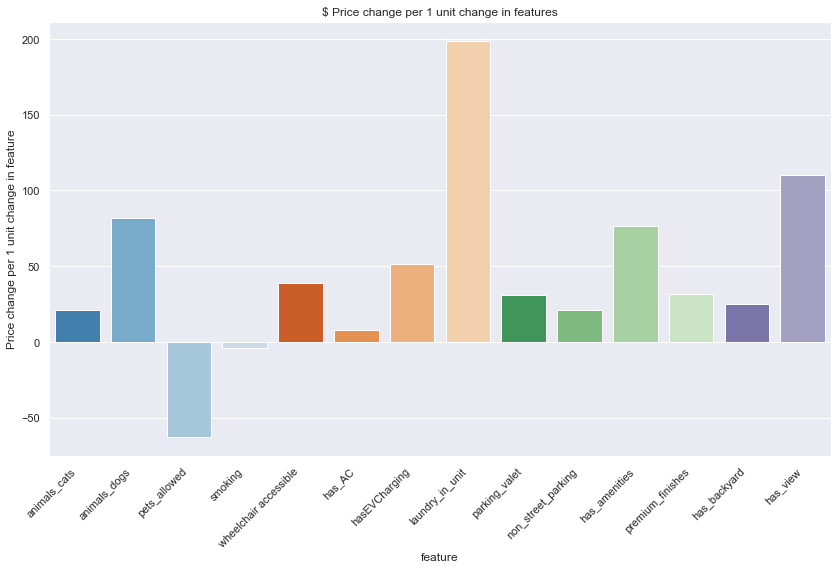

In [218]:
# Plot the model coefficients for each feature
chart = sns.barplot(data=model_coef.reset_index(), x="feature", y="model_coef", palette = 'tab20c')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_ylabel('Price change per 1 unit change in feature')
chart.set_title('$ Price change per 1 unit change in features')

<a id="15"></a> 
### Applications of the price prediction model:

#### Optimizing for market rent:
For renters looking to find a place to rent: they could use this model to predict the market rent for prospective properties, and prioritize the ones that are priced lower than the predicted market rent. This would be a good starting point that narrows down the housing search, optimizing for lowest rent. 

For property owners looking to rent their place on craigslist: they could use this model to predict the market rent for their property and adjust the rent to increase revenue or increase competitiveness. 

#### Cost Benefit analysis of feature coefficients
The business problem came about because properties vary so much it is hard to determine how features influence rental price. By looking at the feature coefficients, the linear model provides some interesting insights, since they can be used by renters and property managers to make informed decisions about pricing and how much features are worth.

For example, properties with in-unit laundry charged an average of 248 dollars/month more in rent than those without. Property owners can take these feature insights and do cost benefit analysis for areas of home improvement.

Renters may use the feature exploration results to decide it is worth the money to choose a property with a higher walkscore (3.76 dollars/1 unit increase in walkscore) to cut down on driving/transportation costs or forgo a car entirely. 
Or it may be cheaper to rent a place with a gym or pool amenity worth an average of 92 dollars/month more which may be more economical than paying for a gym membership.

#### Flagging scams priced below market rent
A contextual piece of information to note when interpreting the model results is that the data comes from past and current Craigslist ads, and Craigslist rental scams are prevalent (accounting for 6% of listings per a study done on this subject), which would appear to bring down the average market rent. 

The listings that are deemed scams do get flagged and are eventually removed, but they do appear on Craigslist and I would estimate that a similar fraction of the data used to build this machine learning model are scams.

Typically, rental scams are posted using real property information copied off a real listing, and are hard to detect. The listed rental price is typically always lower than market value to attract people to click on the ad. 
Unfortunately, these artificially lower prices are not representative of the market rent of a property because it would not be available to rent. This model could be a starting point to flag the properties that are priced lower than market value. 

#### Counterfactual analysis
Users could take this price prediction model to do counterfactual analysis using Bayes Optimization to predict the combinations of features to change the listing price of a property. For example, what are the changes a home owner can make to their property (i.e. features to upgrade) to increase their property value by a certain amount e.g. 100k?









